In [4]:
import transformer as kernel_transformer

from torch.utils.cpp_extension import load
import torch

from matplotlib import pyplot as plt

trampoline = load(
    "extension",
    sources=["trampoline.cu"],
    extra_ldflags=["-lnvrtc", "-lcuda"],
    extra_cuda_cflags=["-g"],
)

/home/normal/.local/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [64]:
import math

@kernel_transformer.kernel()
def sierpinski_kernel(buffer: "u64", width: "u32", height: "u32", depth: "u32"):
    tidx: u32 = u32("%tid.x") + u32("%ntid.x") * u32("%ctaid.x")
    tidy: u32 = u32("%tid.y") + u32("%ntid.y") * u32("%ctaid.y")

    level: u32 = 0
    nx: s32 = tidx
    ny: s32 = tidy
    result:f32 = 0
    while (nx > 0) & (ny > 0) & (level < depth):
        if (nx & ny) == 0:
            result = 1
            break
        nx /= 2
        ny /= 2
        level += 1
    buffer += (width * tidy + tidx) * 4
    
    buffer_global: u64   
    ptx.cvta.to._global.u64(buffer_global, buffer)
    
    ptx.st._global.f32([buffer_global], result)

0.6104320287704468


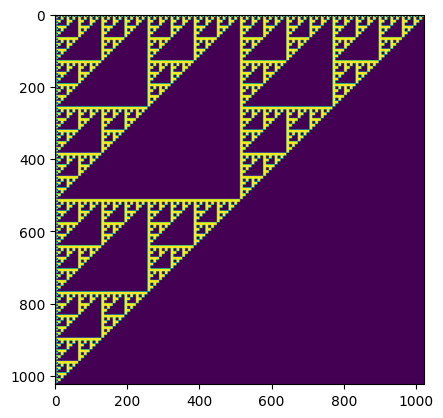

In [65]:
kernel_builder = kernel_transformer.KernelBuilder()
sierpinski_kernel(kernel_builder)
kernel_code = kernel_builder.generate("sm_75")
    

width, height = 1024, 1024

result = torch.zeros((width, height), dtype=torch.float32, device="cuda")

wrapper = trampoline.CuModuleWrapper()
wrapper.load_ptx_code(kernel_code)

block_size_x = 32
block_size_y = 32
start_event = torch.cuda.Event(enable_timing=True)
end_event = torch.cuda.Event(enable_timing=True)
start_event.record()
wrapper.launch_kernel("sierpinski_kernel", (width // block_size_x, height // block_size_y, 1), (block_size_x, block_size_y, 1), (result.data_ptr(), width, height, 4))
end_event.record()

torch.cuda.synchronize()

# Calculate the elapsed time
elapsed_time_ms = start_event.elapsed_time(end_event)
print(elapsed_time_ms)
plt.imshow(result.cpu())